# Imports

In [1]:
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow.ipc as ipc
import pyarrow.feather as feather

from utils.loading import *

In [2]:
NOTEBOOK_PATH = os.getcwd()
DATA_PATH = os.path.join(NOTEBOOK_PATH, "data_youniverse")
CATEGORY = "People & Blogs"

# Data loading

In [ ]:
df_channels_en = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t") 
df_timeseries_en = pd.read_csv(f"{DATA_PATH}/df_timeseries_en.tsv.gz", compression="infer", sep="\t") # 20s
df_feather = feather.read_feather(os.path.join(DATA_PATH, 'yt_metadata_helper.feather'))

### Plot Category distribution

In [ ]:
category_value_counts = df_channels_en["category_cc"].value_counts()

# Plot distribution of categories, emphasis on the People & Blogs category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_value_counts.values, y=category_value_counts.index, orient="h", color="g", saturation=0.6, width=0.5)
plt.title("Distribution of categories")
plt.xlabel("Number of channels")
plt.ylabel("Category")
plt.show();

### Read People & Blogs channels' data

In [ ]:
CATEGORY_FILE_NAME = ''.join(CATEGORY.split(" ")).lower()
CATEGORY_FILE_PATH = os.path.join(DATA_PATH, f"df_channels_{CATEGORY_FILE_NAME}.tsv.gz")

# yt_metadata_filtered = load_and_filter_jsonl_gz_file_by_chunks(os.path.join(DATA_PATH, "yt_metadata_en.jsonl.gz"), CATEGORY)
# yt_metadata_filtered.drop(columns=["categories"], inplace=True)
# yt_metadata_filtered.to_csv(CATEGORY_FILE_PATH, index=False, compression="gzip")
df_yt_metadata_filtered = pd.read_csv(CATEGORY_FILE_PATH, compression="infer")
df_yt_metadata_filtered['upload_date'] = pd.to_datetime(df_yt_metadata_filtered['upload_date'])
df_yt_metadata_filtered.head()

In [ ]:
df_yt_metadata_filtered.info()

# Exploratory Data Analysis

## Upload date analysis

### Plot the proportion of videos uploaded per year coming from People & Blogs category

In [ ]:
all_cc_yearly_video_count = df_feather["upload_date"].dt.year.value_counts().sort_index()
pb_yearly_video_count = df_feather[df_feather["categories"]==CATEGORY]["upload_date"].dt.year.value_counts().sort_index()

# calculate percentage of videos in People & Blogs category
pb_percentage = pb_yearly_video_count / all_cc_yearly_video_count * 100

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=pb_percentage.index, y=pb_percentage.values, color="g", marker="o", markersize=10)
plt.xticks(rotation=45)
plt.ylabel("Percentage of Videos [%]")
plt.xlabel("Upload Year")
plt.title("Percentage of Videos Uploaded In The People & Blogs Category per Year (2005-2019)")
plt.show();

### Category evolution over time

In [ ]:
# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=pb_yearly_video_count.index, y=pb_yearly_video_count.values, color="g", saturation=0.6)
plt.xticks(rotation=45)
plt.ylabel("Total Number of Videos")
plt.xlabel("Year")
plt.title("Total Number of Videos Uploaded In The People & Blogs Category per Year (2005-2019)")
plt.show();

### Apply log scale to the y-axis

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pb_yearly_video_count.index, y=pb_yearly_video_count.values, color="g", saturation=0.6)
plt.yscale("log")
plt.xticks(rotation=45)
plt.ylabel("Total Number of Videos")
plt.xlabel("Year")
plt.title("Total Number of Videos Uploaded In The People & Blogs Category per Year (2005-2019)")
plt.show();

## Video duration distribution

In [ ]:
df_yt_metadata_filtered.sample(5)

In [ ]:
df_feather['upload_year'] = df_feather['upload_date'].dt.year

In [ ]:
all_cc_mean_video_duration = df_feather.groupby("upload_year")["duration"].mean()
pb_mean_video_duration = df_feather[df_feather["categories"]==CATEGORY].groupby("upload_year")["duration"].mean()

plt.figure(figsize=(10, 6))
sns.lineplot(x=all_cc_mean_video_duration.index, y=all_cc_mean_video_duration.values, color="b", marker="o", markersize=10, label="All Categories")
sns.lineplot(x=pb_mean_video_duration.index, y=pb_mean_video_duration.values, color="g", marker="o", markersize=10, label="People & Blogs")
plt.xticks(rotation=45)
plt.ylabel("Mean Video Duration [s]")
plt.xlabel("Upload Year")
plt.title("Mean Video Duration per Year (2005-2019) for All Categories vs. People & Blogs")
plt.legend()
plt.show();

## Like to dislike ratio analysis

In [ ]:
df_feather["like_rate"] = df_feather["like_count"] / (df_feather["like_count"] + df_feather["dislike_count"])

df_feather.sample(5)

In [ ]:
df_feather[df_feather['like_rate'].isna()].view_count.describe()

In [ ]:
df_non_na_like_rate = df_feather[df_feather["like_rate"].notnull()]

all_cc_mean_like_rate = df_non_na_like_rate.groupby("upload_year")["like_rate"].agg(["mean", "std"])
pb_mean_like_rate = df_non_na_like_rate[df_non_na_like_rate["categories"]==CATEGORY].groupby("upload_year")["like_rate"].agg(["mean", "std"])

plt.figure(figsize=(10, 6))
plt.errorbar(x=all_cc_mean_like_rate.index, y=all_cc_mean_like_rate["mean"], yerr=all_cc_mean_like_rate["std"], color="b", marker="o", markersize=10, label="All Categories")
plt.errorbar(x=pb_mean_like_rate.index, y=pb_mean_like_rate["mean"], yerr=pb_mean_like_rate["std"], color="g", marker="o", markersize=10, label="People & Blogs")
plt.xticks(rotation=45)
plt.ylabel("Mean Like/Dislike Ratio")
plt.xlabel("Upload Year")
plt.title("Mean Like/Dislike Ratio per Year (2005-2019) for All Categories vs. People & Blogs")
plt.legend()
plt.show();

## Tag Analysis

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# DONT RUN THIS CELL, LOAD INSTEAD

In [ ]:
tags = df_yt_metadata_filtered['tags'].str.split(',', expand=True).stack()
tags = tags.str.strip().str.lower()
tags = pd.Series(tags[tags != ''].unique())
# save tags to file
tags.to_csv(os.path.join(DATA_PATH, "tags.tsv.gz"), index=False, compression="gzip")

In [30]:
tags = pd.read_csv(os.path.join(DATA_PATH, "tags.tsv.gz"), compression="infer", header=None, names=["tag"])['tag'].dropna()

In [32]:
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust the number of features
tfidf_matrix = vectorizer.fit_transform(tags[:1_000_000])

In [33]:
n_clusters = 10  # Adjust based on your data
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(tfidf_matrix)


/Users/hamzezi/anaconda3/envs/ada/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [35]:
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(np.asarray(tfidf_matrix.todense()))

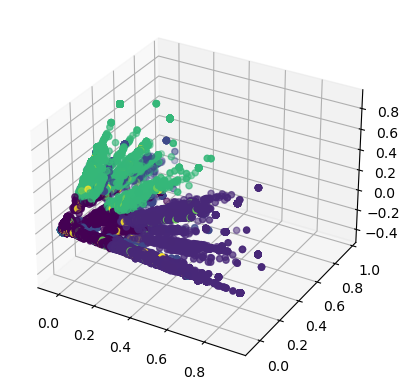

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data[:,0], reduced_data[:,1], reduced_data[:,2], c=clusters)
plt.show()